In [11]:
import math
import numpy as np
from scipy.stats import multivariate_normal

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:
# 1. Initialize variational factors

#  a. Select mean and variance of the data set
dataset_i = 150
dataset_mean = [0, 0]
dataset_stddev = 5

# This is a hyperparameter, a prior variance
dataset_variance = dataset_stddev**2

# To offer hyperparameter that's not the actual dataset variance
suggested_dataset_variance = 20

#  b. Select initial mixture component variances and means
mixture_components_k = 3
mixture_means = []
mixture_variances = np.zeros(mixture_components_k)
mixture_variances_prior = np.zeros(mixture_components_k)
for index in range(mixture_components_k):

    mixture_variances_prior[index] = np.random.random_sample() * dataset_variance
    mixture_variances[index] = mixture_variances_prior[index]
    x, y = np.random.multivariate_normal([0,0],
                                         mixture_variances[index] * np.identity(2),
                                         1).T
    mixture_means.append([x[0], y[0]])

# Save log prior for cluster assignment c_i
c_i_logprior = -1 * np.log(mixture_components_k)

# Previous ELBO is initialized with arbitray positive value (since ELBO will be negative)
prev_ELBO = 100

# ELBO is initialized at 0, but will be set within the first iteration to a real value
ELBO = -100

In [13]:
# 2. Generate data set

#   a. Zeroed data set
data_x = np.zeros(dataset_i)
data_y = np.zeros(dataset_i)
data_c = [0] * dataset_i
data_phi = []
for index in range(dataset_i):
    data_phi.append([])
    for index2 in range(mixture_components_k):
        data_phi[index].append(0.0)
data_phi = np.array(data_phi)

#   b. Generate observations
for index in range(dataset_i):

    # Choose initial cluster assignment c_i (categorical)
    c_i = np.random.choice(mixture_components_k)
    data_c[index] = c_i

    # Generate a random observation from Gaussian mixture c_i with its mean, variance of 1
    x, y = np.random.multivariate_normal(mixture_means[c_i],
                                         1 * np.identity(2),
                                         1).T
    data_x[index] = x[0]
    data_y[index] = y[0]

In [14]:
# ELBO convergence loop
# iteration = 0
ELBO_list = []
while abs(ELBO - prev_ELBO) > 0.001:

    # print "Iteration {0}".format(iteration)
    # iteration += 1

    # Save previous ELBO value
    prev_ELBO = ELBO

    # 3. Update the variational factors while converging on ELBO

    # Arrays to store E[mu_k] values per iteration to save on computation
    e_mk_xi_vector = np.zeros(dataset_i)
    e_mk2_d2_vector = np.zeros(mixture_components_k)
    e_mk2_d2_filled_vector = np.zeros(mixture_components_k)        
    phi_ik_nonexp_vector = np.zeros(dataset_i)

    for index in range(dataset_i):

        # Precompute E[mu_k;m,s^2] * x_i and E[(mu_k)^2;m,s^2] for log-sum-exp
        for index2 in range(mixture_components_k):

            # Computing expected values
            e_mk_xi = abs(np.dot(np.array([mixture_means[index2][0], mixture_means[index2][1]]),
                          np.array([data_x[index], data_y[index]])))
            e_mk_xi_vector[index] = e_mk_xi

            if not e_mk2_d2_filled_vector[index2]:
                e_mk2_d2 = abs(np.dot(np.array([mixture_means[index2][0], mixture_means[index2][1]]),
                               np.array([mixture_means[index2][0], mixture_means[index2][1]])) / 2.0)                
                e_mk2_d2_vector[index2] = e_mk2_d2
                e_mk2_d2_filled_vector[index2] = 1
            else:
                e_mk2_d2 = e_mk2_d2_vector[index2]

            # print "e_mk_xi: {0}".format(e_mk_xi)
            # print "e_mk2_d2: {0}".format(e_mk2_d2)                

            phi_ik_nonexp_vector[index] = e_mk_xi - e_mk2_d2

    # Values for log-sum-exp
    a = phi_ik_nonexp_vector[np.argmax(phi_ik_nonexp_vector)]
    log_sum_exp = 0
    for index in range(dataset_i):
        log_sum_exp += math.exp(phi_ik_nonexp_vector[index] - a)
    log_sum_exp = np.log(log_sum_exp)

    # print "a: {0}".format(a)
    # print "log_sum_exp: {0}".format(log_sum_exp)

    # Update phi for each observation
    for index in range(dataset_i):
        for index2 in range(mixture_components_k):

            # Update phi (using log-sum-exp trick)
            log_phi_ik = phi_ik_nonexp_vector[index] - a - log_sum_exp
            phi_ik = math.exp(log_phi_ik)
            data_phi[index][index2] = phi_ik

            # print "phi_ik: {0}".format(data_phi[index][index2])

            # Update cluster assignment (?)
            data_c[index] = np.argmax(data_phi[index])

    # Update mixture means and variances
    for index in range(mixture_components_k):

        new_mm_x = 0
        new_mm_y = 0

        # Sum all phi * data
        for index2 in range(dataset_i):
            new_mm_x += data_phi[index2][index] * data_x[index2]
            new_mm_y += data_phi[index2][index] * data_y[index2]

        sum_phi_ik = 0
        for index2 in range(dataset_i):
            sum_phi_ik += data_phi[index2][index]

        # Calculate new s_k^2 (will be used in new m_k)
        new_mv = 1.0 / ((1.0/mixture_variances[index]) + sum_phi_ik)

        # Divide new means by [(1/sigma^2) + sum(phi)]
        new_mm_x *= new_mv
        new_mm_y *= new_mv

        # Save new m_k
        mixture_means[index][0] = new_mm_x
        mixture_means[index][1] = new_mm_y

        # Save new (s_k)^2
        mixture_variances[index] = new_mv

    # print "Mixture variances: {0}".format(mixture_variances)

    # if True:
    #     for index2 in range(mixture_components_k):
    #         print "Component[{0}]:\n\tmean: [{1},{2}]\n\tvariance: {3}".format(index2, 
    #             mixture_means[index2][0], mixture_means[index2][1], mixture_variances[index2])
    #     return

    # 4. Compute ELBO

    #  a. Sum of expected values of log p(m_k)
    sum_e_logpm_k = 0
    for index2 in range(mixture_components_k):
        sum_e_logpm_k += np.log(multivariate_normal.pdf(x = [mixture_means[index2][0], mixture_means[index2][1]],
                                                        mean = [0,0],
                                                        cov = math.pow(mixture_variances[index2], 2) * np.identity(2)))

    #  b. Sum of expected values of log p(c_i) + log p(x_i|c_i)
    sum_e_logpc_i = 0
    for index2 in range(dataset_i):

        # Alternate calculation
        sum_e_logpc_i += -1 * np.log(mixture_components_k)
        e_mk_xi = np.dot(np.array([mixture_means[data_c[index2]][0], mixture_means[data_c[index2]][1]]),
                         np.array([data_x[index2], data_y[index2]]))
        e_mk2_d2 = np.dot(np.array([mixture_means[data_c[index2]][0], mixture_means[data_c[index2]][1]]),
                          np.array([mixture_means[data_c[index2]][0], mixture_means[data_c[index2]][1]])) / 2.0
        e_logpx_i_mu_i = e_mk_xi - e_mk2_d2
        # print "Term 1: {0} Term 2: {1}".format(e_mk_xi, e_mk2_d2)
        sum_e_logpc_i += e_logpx_i_mu_i

    #  c. Sum of expected values of mean-field variational factor log q(c_i)
    sum_logq_c_i = 0
    for index2 in range(dataset_i):

        q_c_i = c_i_logprior

        e_mk_xi = np.dot(np.array([mixture_means[data_c[index2]][0], mixture_means[data_c[index2]][1]]),
                         np.array([data_x[index2], data_y[index2]]))
        e_mk2_d2 = np.dot(np.array([mixture_means[data_c[index2]][0], mixture_means[data_c[index2]][1]]),
                          np.array([mixture_means[data_c[index2]][0], mixture_means[data_c[index2]][1]])) / 2.0
        sum_e_logpx_i_mu_i = e_mk_xi - e_mk2_d2   
        q_c_i += sum_e_logpx_i_mu_i
        q_c_i = np.log(abs(q_c_i))
        sum_logq_c_i += q_c_i


    # d. Sum of expected values of mean-field variational factor log q(mu_k)
    sum_logq_mu_k = 0
    for index2 in range(mixture_components_k):

        # Determine (sum phi_ik * x_i) * m_k
        sum_phi_ik_x_i_x = 0
        sum_phi_ik_x_i_y = 0
        for index3 in range(dataset_i):
            sum_phi_ik_x_i_x += data_phi[index3][index2] * data_x[index3]
            sum_phi_ik_x_i_y += data_phi[index3][index2] * data_y[index3]            
        mu_k_term = np.dot(np.array([sum_phi_ik_x_i_x, sum_phi_ik_x_i_y]),
                           np.array([mixture_means[index2][0], mixture_means[index2][1]]))

        # Determine (1/2sigma^2 + sum(phi_ik)/2) * (mu_k)^2
        sum_phi_ik = 0
        for index3 in range(dataset_i):
            sum_phi_ik += data_phi[index3][index2]
        mu_k2_term = (1.0/2*mixture_variances[index2]) + (sum_phi_ik/2.0)
        mu_k2_term *= np.dot(np.array([mixture_means[index2][0], mixture_means[index2][1]]),
                             np.array([mixture_means[index2][0], mixture_means[index2][1]]))

        e_term = np.log(abs(mu_k_term - mu_k2_term))
        sum_logq_mu_k += e_term

    # if True:
    #     print "sum_e_logpm_k: {0}".format(sum_e_logpm_k)
    #     print "sum_e_logpc_i + sum_e_logpx_i_mu_i: {0}".format(sum_e_logpc_i)
    #     print "sum_logq_c_i: {0}".format(sum_logq_c_i)
    #     print "sum_logq_mu_k: {0}".format(sum_logq_mu_k)

    # e. Combine ELBO terms        
    ELBO = sum_e_logpm_k + sum_e_logpc_i - sum_logq_c_i - sum_logq_mu_k
    ELBO_list.append(ELBO)

    print "prev ELBO: {0}".format(prev_ELBO)
    print "ELBO: {0}".format(ELBO)

prev ELBO: -100
ELBO: -5257.62739228
prev ELBO: -5257.62739228
ELBO: -1644.46682635
prev ELBO: -1644.46682635
ELBO: -927.917266403
prev ELBO: -927.917266403
ELBO: -669.75311215
prev ELBO: -669.75311215
ELBO: -548.088279986
prev ELBO: -548.088279986
ELBO: -474.886992602
prev ELBO: -474.886992602
ELBO: -425.749069156
prev ELBO: -425.749069156
ELBO: -389.014455608
prev ELBO: -389.014455608
ELBO: -357.252616078
prev ELBO: -357.252616078
ELBO: -327.872109996
prev ELBO: -327.872109996
ELBO: -299.259882914
prev ELBO: -299.259882914
ELBO: -270.356019642
prev ELBO: -270.356019642
ELBO: -240.241664272
prev ELBO: -240.241664272
ELBO: -207.632633163
prev ELBO: -207.632633163
ELBO: -169.596419861
prev ELBO: -169.596419861
ELBO: -113.431538106
prev ELBO: -113.431538106
ELBO: -53.395142282
prev ELBO: -53.395142282
ELBO: -60.4458575629
prev ELBO: -60.4458575629
ELBO: -100.141308946
prev ELBO: -100.141308946
ELBO: -117.465137688
prev ELBO: -117.465137688
ELBO: -125.727739106
prev ELBO: -125.727739106
E

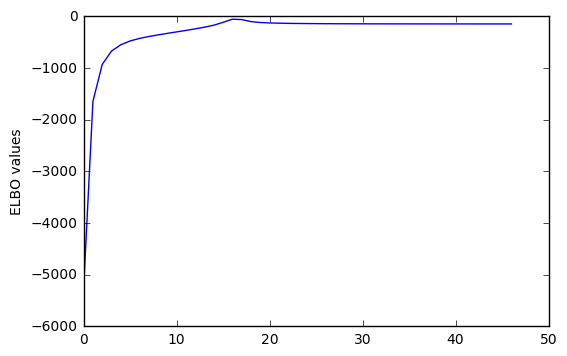

In [15]:
plt.plot(ELBO_list)
plt.ylabel("ELBO values")
plt.show()
    